In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch.utils.data import random_split
from tensorboardX import SummaryWriter
import matplotlib.pyplot as plt
import numpy as np
import time

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['font.size'] = 24

In [4]:
batch_size = 50
learning_rate = 0.0001
num_epoch = 10
data_route = "../../data/"


In [5]:
def train_model(model, train_loader, test_loader, unfreeze=2*num_epoch):
    unfreeze -= 1
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    train_loss = []
    train_accu = []
    test_accu = []
    i = 0
    since = time.time()
    for epoch in range(num_epoch):
        if num_epoch >= unfreeze:
            for param in model.parameters():
                param.requires_grad = True
        print(f"Current epoch: {epoch + 1}\t----------------------------------------------")
        for data, target in train_loader:
            model.train()
            data, target = data.to(device), target.to(device)
            data, target = Variable(data), Variable(target)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            train_loss.append(loss.data.item())
            optimizer.step()
            prediction = output.data.max(1)[1]
            accuracy = prediction.eq(target.data).sum() / batch_size * 100
            train_accu.append(accuracy.item())
            if i % (10000 // batch_size) == 0:
                print('\tTrain Step: {}\tLoss: {:.3f}\tAccuracy: {:.3f}'.format(i, loss.data.item(), accuracy))
                test_accu.append(test_model(model, test_loader))
            i += 1

    time_elapsed = time.time() - since
    print(f"Time elapsed: {time_elapsed}")
    return train_loss, train_accu, test_accu, output

In [6]:
def test_model(model, test_loader):
    model.eval()
    correct = 0
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        prediction = output.data.max(1)[1]
        correct += prediction.eq(target.data).sum()
    accuracy = 100. * correct / len(test_loader.dataset)
    accuracy = accuracy.item()
    print('\tTest set: Accuracy: {:.2f}%\n'.format(accuracy))
    return accuracy

In [7]:
def write_logs(train_loss, train_accu, test_accu, comment=""):
    writer = SummaryWriter(comment=comment)
    for step in range(len(train_loss)):
        writer.add_scalar('train/loss', train_loss[step], step)
        writer.add_scalar('train/accuracy', train_accu[step], step)
    for step in range(len(test_accu)):
        writer.add_scalar('test/accuracy', test_accu[step], step)
    writer.close()

In [8]:
def show_plots(train_loss, train_accu, test_accu):
    plt.subplot(1, 3, 1)
    plt.plot(np.arange(len(train_loss)), train_loss)
    plt.subplot(1, 3, 2)
    plt.plot(np.arange(len(train_accu)), train_accu)
    plt.subplot(1, 3, 3)
    plt.plot(np.arange(len(test_accu)), test_accu)


In [9]:
def write_show(train_loss, train_accu, test_accu, comment=""):
    write_logs(train_loss, train_accu, test_accu, comment)
    show_plots(train_loss, train_accu, test_accu)

In [10]:
def freeze(model):
    for names, param in model.named_parameters():
        if names.startswith("conv_block"):
            param.requires_grad = False
        print(names, param.requires_grad)

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
torch.cuda.is_available()

cuda:0


True

In [12]:
class MnistModel(nn.Module):
    def __init__(self):
        super(MnistModel, self).__init__()
        self.conv_block = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Conv2d(1, 32, kernel_size=2),
            nn.Dropout(),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 32, kernel_size=3),
            nn.Dropout(),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3),
            nn.Dropout(),
        )
        self.linear = nn.Sequential(
            nn.Linear(3*3*64, 256),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.conv_block(x)
        x = x.view(-1, x.size(1) * x.size(2) * x.size(2))
        x = self.linear(x)
        return F.log_softmax(x)


In [13]:
batch_size = 50
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(data_route, train=True, download=True, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True)

In [14]:
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(data_route, train=False, transform=transforms.ToTensor()),
    batch_size=1000)

In [15]:
model = MnistModel()
model

MnistModel(
  (conv_block): Sequential(
    (0): ReLU(inplace=True)
    (1): Conv2d(1, 32, kernel_size=(2, 2), stride=(1, 1))
    (2): Dropout(p=0.5, inplace=False)
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (6): Dropout(p=0.5, inplace=False)
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (10): Dropout(p=0.5, inplace=False)
  )
  (linear): Sequential(
    (0): Linear(in_features=576, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=10, bias=True)
  )
)

In [16]:
for p in model.parameters():
    print(p.size())

torch.Size([32, 1, 2, 2])
torch.Size([32])
torch.Size([32, 32, 3, 3])
torch.Size([32])
torch.Size([64, 32, 3, 3])
torch.Size([64])
torch.Size([256, 576])
torch.Size([256])
torch.Size([10, 256])
torch.Size([10])


In [17]:
train_loss, train_accu, test_accu, output = train_model(model, train_loader, test_loader)

Current epoch: 1	----------------------------------------------
	Train Step: 0	Loss: 2.284	Accuracy: 16.000
	Test set: Accuracy: 8.89%

	Train Step: 200	Loss: 0.591	Accuracy: 82.000
	Test set: Accuracy: 84.12%

	Train Step: 400	Loss: 0.414	Accuracy: 88.000
	Test set: Accuracy: 87.98%

	Train Step: 600	Loss: 0.461	Accuracy: 86.000
	Test set: Accuracy: 89.52%

	Train Step: 800	Loss: 0.574	Accuracy: 84.000
	Test set: Accuracy: 90.42%

	Train Step: 1000	Loss: 0.534	Accuracy: 88.000
	Test set: Accuracy: 92.04%

Current epoch: 2	----------------------------------------------
	Train Step: 1200	Loss: 0.752	Accuracy: 78.000
	Test set: Accuracy: 92.84%

	Train Step: 1400	Loss: 0.197	Accuracy: 96.000
	Test set: Accuracy: 93.92%

	Train Step: 1600	Loss: 0.313	Accuracy: 94.000
	Test set: Accuracy: 94.66%

	Train Step: 1800	Loss: 0.253	Accuracy: 94.000
	Test set: Accuracy: 95.20%

	Train Step: 2000	Loss: 0.095	Accuracy: 96.000
	Test set: Accuracy: 95.69%

	Train Step: 2200	Loss: 0.176	Accuracy: 96.0

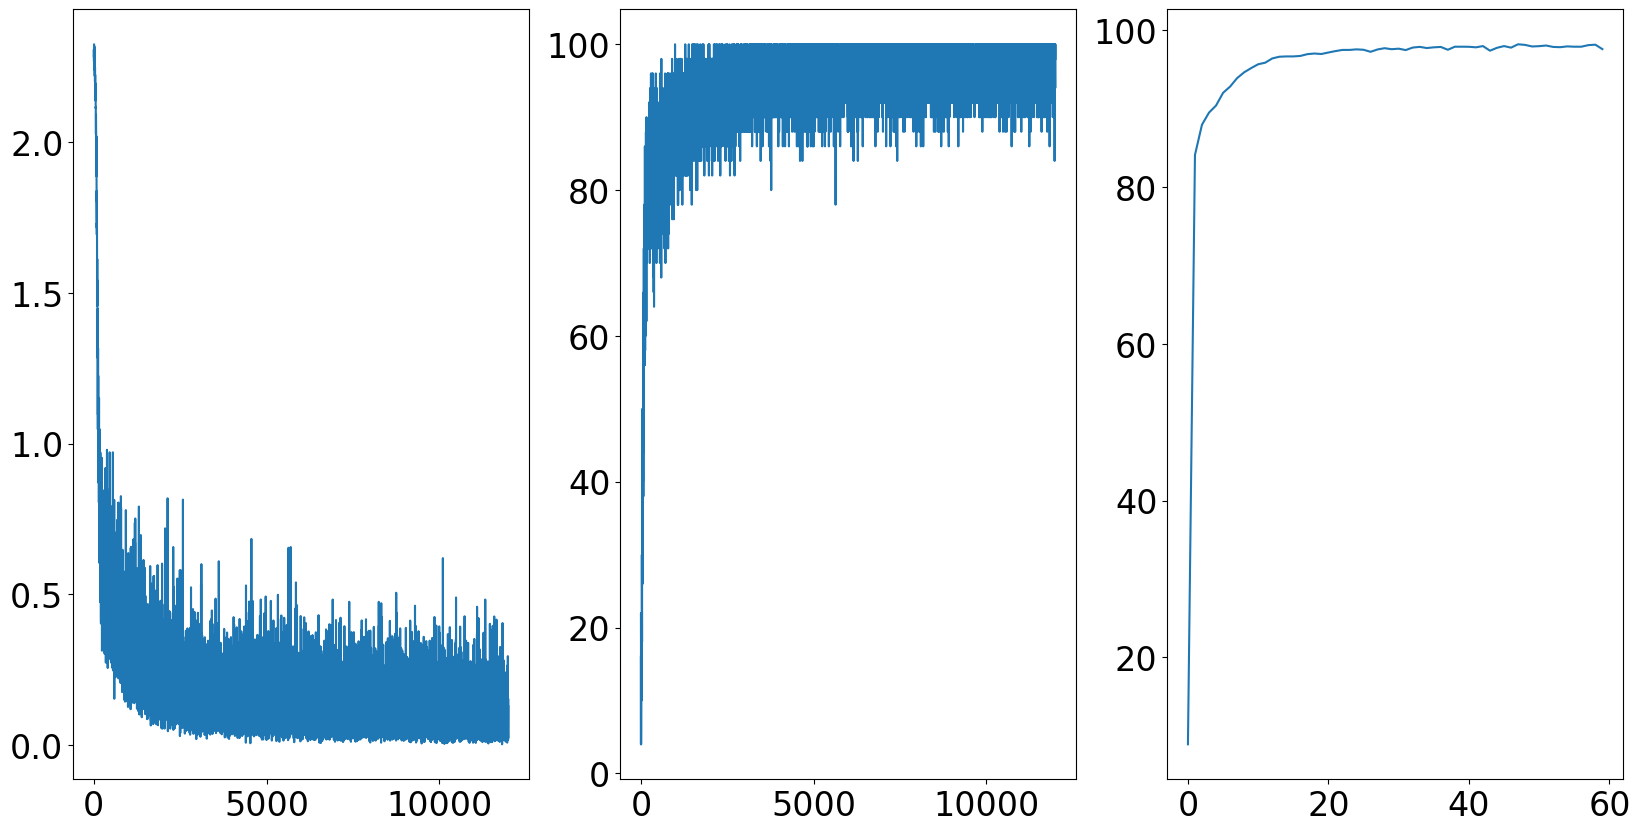

In [18]:
write_show(train_loss, train_accu, test_accu, "-model-MNIST")

In [19]:
%load_ext tensorboard

In [20]:
%tensorboard --logdir runs

Launching TensorBoard...

In [21]:
from tensorboard import notebook
notebook.list()

Known TensorBoard instances:
  - port 6006: logdir runs (started 0:00:00 ago; pid 20572)


In [22]:
train_loader2 = torch.utils.data.DataLoader(
    datasets.FashionMNIST(data_route, train=True, download=True, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True)
test_loader2 = torch.utils.data.DataLoader(
    datasets.FashionMNIST(data_route, train=False, transform=transforms.ToTensor()),
    batch_size=1000)

In [23]:
model2 = MnistModel()
model2

MnistModel(
  (conv_block): Sequential(
    (0): ReLU(inplace=True)
    (1): Conv2d(1, 32, kernel_size=(2, 2), stride=(1, 1))
    (2): Dropout(p=0.5, inplace=False)
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (6): Dropout(p=0.5, inplace=False)
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (10): Dropout(p=0.5, inplace=False)
  )
  (linear): Sequential(
    (0): Linear(in_features=576, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=10, bias=True)
  )
)

In [24]:
train_loss2, train_accu2, test_accu2, output2 = train_model(model2, train_loader2, test_loader2)

Current epoch: 1	----------------------------------------------
	Train Step: 0	Loss: 2.308	Accuracy: 8.000
	Test set: Accuracy: 10.00%

	Train Step: 200	Loss: 0.688	Accuracy: 76.000
	Test set: Accuracy: 68.22%

	Train Step: 400	Loss: 0.943	Accuracy: 66.000
	Test set: Accuracy: 69.51%

	Train Step: 600	Loss: 0.819	Accuracy: 68.000
	Test set: Accuracy: 71.08%

	Train Step: 800	Loss: 0.855	Accuracy: 68.000
	Test set: Accuracy: 73.48%

	Train Step: 1000	Loss: 0.596	Accuracy: 80.000
	Test set: Accuracy: 74.37%

Current epoch: 2	----------------------------------------------
	Train Step: 1200	Loss: 0.578	Accuracy: 76.000
	Test set: Accuracy: 73.91%

	Train Step: 1400	Loss: 0.495	Accuracy: 88.000
	Test set: Accuracy: 76.45%

	Train Step: 1600	Loss: 0.615	Accuracy: 70.000
	Test set: Accuracy: 73.67%

	Train Step: 1800	Loss: 0.755	Accuracy: 66.000
	Test set: Accuracy: 77.54%

	Train Step: 2000	Loss: 0.660	Accuracy: 76.000
	Test set: Accuracy: 77.45%

	Train Step: 2200	Loss: 0.817	Accuracy: 76.0

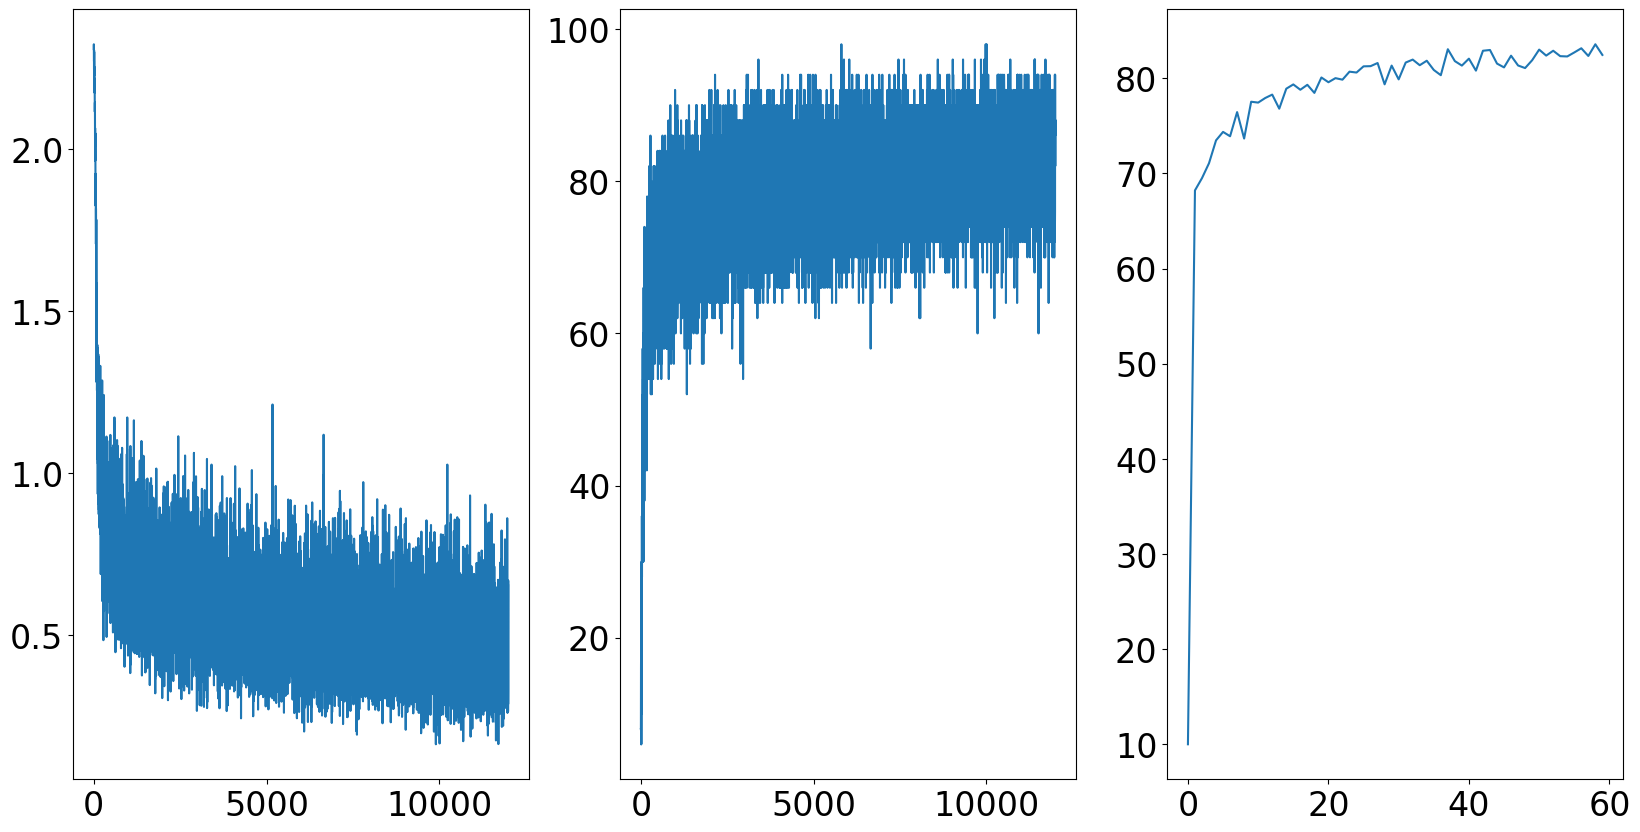

In [25]:
write_show(train_loss2, train_accu2, test_accu2, "-model-Fashion-MNIST")

In [26]:
params = model.state_dict()
params

OrderedDict([('conv_block.1.weight',
              tensor([[[[-0.1868, -0.0554],
                        [ 0.5326,  0.1816]]],
              
              
                      [[[-0.0465, -0.1012],
                        [ 0.4160, -0.2690]]],
              
              
                      [[[ 0.1673, -0.1884],
                        [-0.3490, -0.0302]]],
              
              
                      [[[ 0.0721,  0.4913],
                        [ 0.1264, -0.3117]]],
              
              
                      [[[ 0.3503,  0.2044],
                        [-0.0772, -0.2260]]],
              
              
                      [[[-0.4372, -0.3412],
                        [ 0.6182,  0.0148]]],
              
              
                      [[[ 0.0396, -0.4610],
                        [ 0.0222, -0.1905]]],
              
              
                      [[[-0.3953, -0.2588],
                        [ 0.0652, -0.4253]]],
              
              
   

In [27]:
model3 = MnistModel()
model3.load_state_dict(params)

<All keys matched successfully>

In [28]:
train_loss3, train_accu3, test_accu3, output3 = train_model(model3, train_loader2, test_loader2)

Current epoch: 1	----------------------------------------------
	Train Step: 0	Loss: 5.452	Accuracy: 10.000
	Test set: Accuracy: 7.27%

	Train Step: 200	Loss: 1.193	Accuracy: 54.000
	Test set: Accuracy: 61.68%

	Train Step: 400	Loss: 0.729	Accuracy: 68.000
	Test set: Accuracy: 69.85%

	Train Step: 600	Loss: 0.790	Accuracy: 68.000
	Test set: Accuracy: 73.30%

	Train Step: 800	Loss: 0.704	Accuracy: 72.000
	Test set: Accuracy: 74.13%

	Train Step: 1000	Loss: 0.688	Accuracy: 78.000
	Test set: Accuracy: 76.35%

Current epoch: 2	----------------------------------------------
	Train Step: 1200	Loss: 0.519	Accuracy: 84.000
	Test set: Accuracy: 77.03%

	Train Step: 1400	Loss: 0.784	Accuracy: 72.000
	Test set: Accuracy: 78.44%

	Train Step: 1600	Loss: 0.518	Accuracy: 86.000
	Test set: Accuracy: 79.70%

	Train Step: 1800	Loss: 0.498	Accuracy: 76.000
	Test set: Accuracy: 79.57%

	Train Step: 2000	Loss: 0.539	Accuracy: 80.000
	Test set: Accuracy: 80.00%

	Train Step: 2200	Loss: 0.731	Accuracy: 70.0

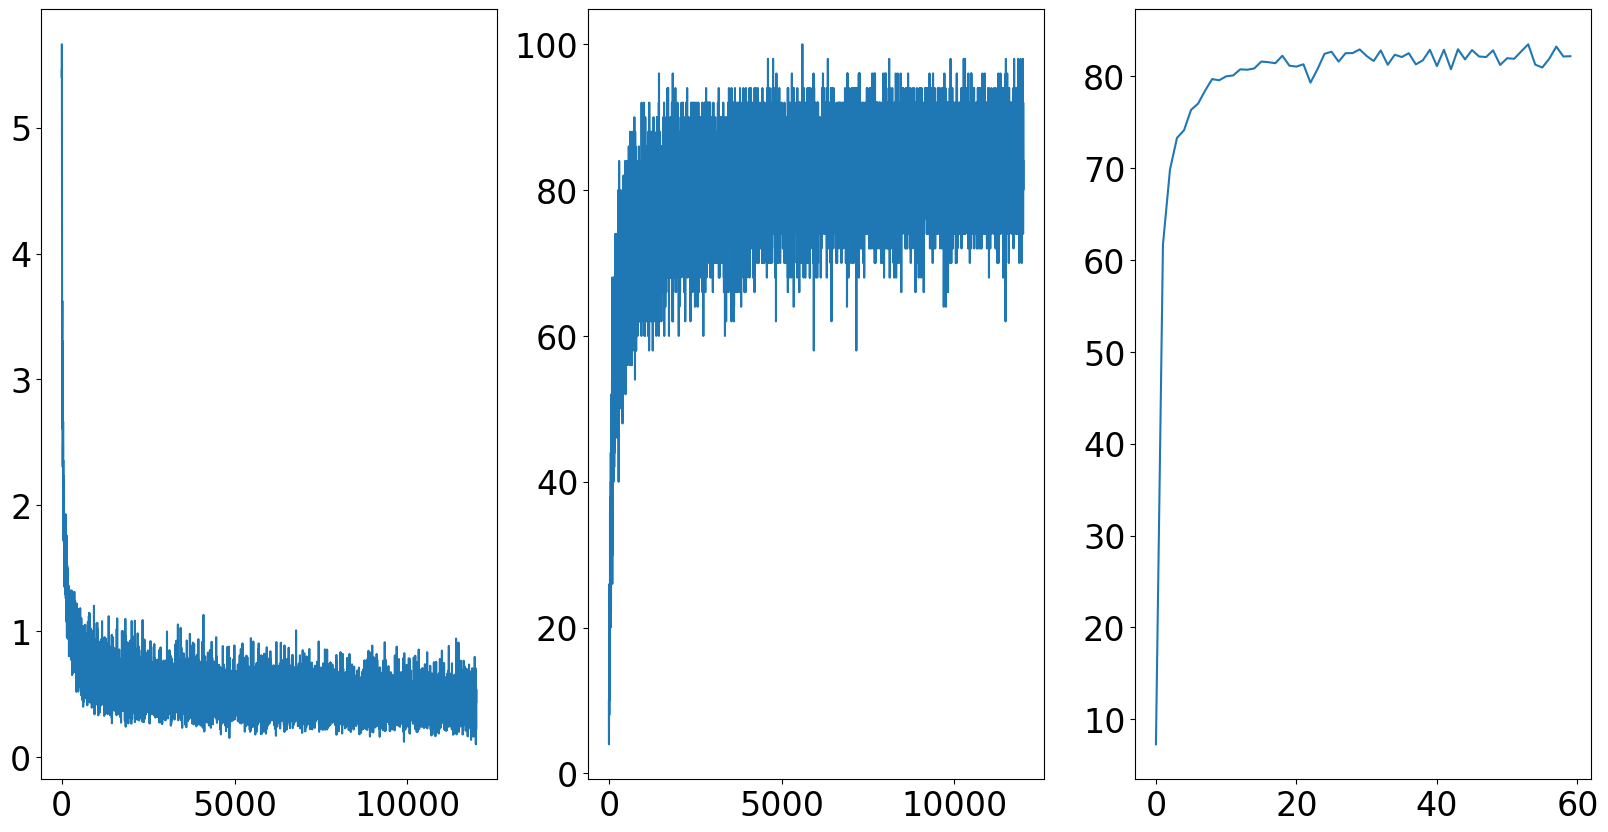

In [29]:
write_show(train_loss3, train_accu3, test_accu3, "-model-saved-params")

In [30]:
model4 = MnistModel()
model4.load_state_dict(params)
freeze(model4)

conv_block.1.weight False
conv_block.1.bias False
conv_block.5.weight False
conv_block.5.bias False
conv_block.9.weight False
conv_block.9.bias False
linear.0.weight True
linear.0.bias True
linear.1.weight True
linear.1.bias True


In [31]:
train_loss4, train_accu4, test_accu4, output4 = train_model(model4, train_loader2, test_loader2)

Current epoch: 1	----------------------------------------------
	Train Step: 0	Loss: 5.674	Accuracy: 4.000
	Test set: Accuracy: 7.15%

	Train Step: 200	Loss: 1.325	Accuracy: 54.000
	Test set: Accuracy: 61.60%

	Train Step: 400	Loss: 1.033	Accuracy: 58.000
	Test set: Accuracy: 68.81%

	Train Step: 600	Loss: 0.813	Accuracy: 66.000
	Test set: Accuracy: 72.61%

	Train Step: 800	Loss: 0.871	Accuracy: 64.000
	Test set: Accuracy: 75.83%

	Train Step: 1000	Loss: 0.698	Accuracy: 70.000
	Test set: Accuracy: 76.94%

Current epoch: 2	----------------------------------------------
	Train Step: 1200	Loss: 0.685	Accuracy: 76.000
	Test set: Accuracy: 77.96%

	Train Step: 1400	Loss: 0.632	Accuracy: 74.000
	Test set: Accuracy: 79.10%

	Train Step: 1600	Loss: 0.775	Accuracy: 80.000
	Test set: Accuracy: 79.53%

	Train Step: 1800	Loss: 0.471	Accuracy: 84.000
	Test set: Accuracy: 79.77%

	Train Step: 2000	Loss: 0.594	Accuracy: 74.000
	Test set: Accuracy: 79.54%

	Train Step: 2200	Loss: 0.876	Accuracy: 62.00

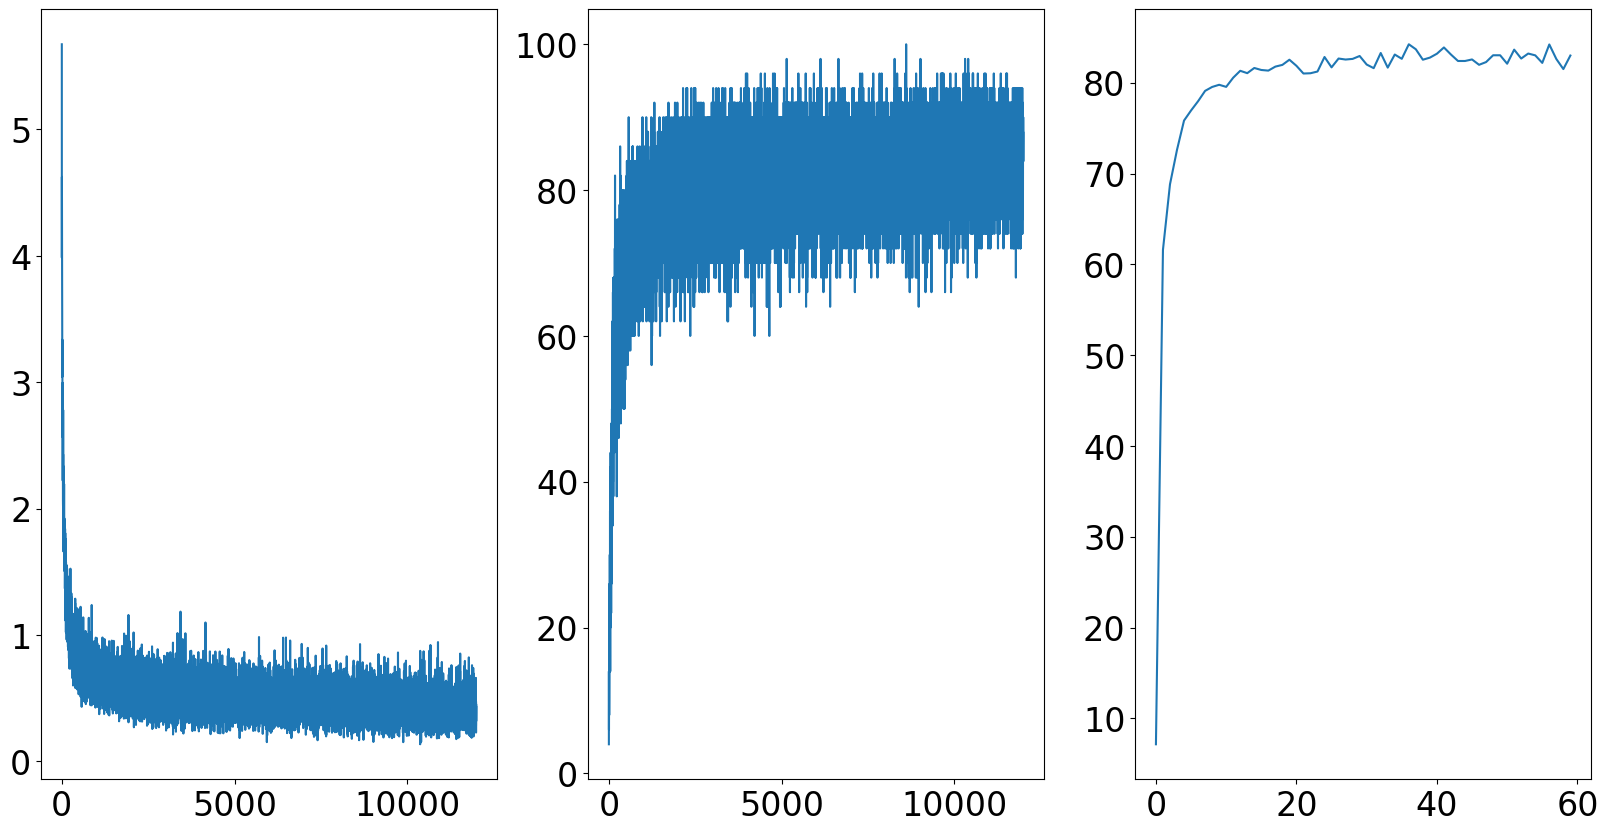

In [32]:
write_show(train_loss4, train_accu4, test_accu4, "-model-freeze")


In [33]:
model5 = MnistModel()
model5.load_state_dict(params)
freeze(model5)

conv_block.1.weight False
conv_block.1.bias False
conv_block.5.weight False
conv_block.5.bias False
conv_block.9.weight False
conv_block.9.bias False
linear.0.weight True
linear.0.bias True
linear.1.weight True
linear.1.bias True


In [34]:
train_loss5, train_accu5, test_accu5, output5 = train_model(model5, train_loader2, test_loader2, num_epoch // 2)

Current epoch: 1	----------------------------------------------
	Train Step: 0	Loss: 5.734	Accuracy: 6.000
	Test set: Accuracy: 7.13%

	Train Step: 200	Loss: 1.372	Accuracy: 48.000
	Test set: Accuracy: 61.41%

	Train Step: 400	Loss: 0.766	Accuracy: 76.000
	Test set: Accuracy: 69.28%

	Train Step: 600	Loss: 0.694	Accuracy: 64.000
	Test set: Accuracy: 72.99%

	Train Step: 800	Loss: 0.604	Accuracy: 76.000
	Test set: Accuracy: 74.30%

	Train Step: 1000	Loss: 0.560	Accuracy: 78.000
	Test set: Accuracy: 76.53%

Current epoch: 2	----------------------------------------------
	Train Step: 1200	Loss: 0.694	Accuracy: 74.000
	Test set: Accuracy: 78.07%

	Train Step: 1400	Loss: 0.440	Accuracy: 88.000
	Test set: Accuracy: 78.74%

	Train Step: 1600	Loss: 0.630	Accuracy: 78.000
	Test set: Accuracy: 79.83%

	Train Step: 1800	Loss: 0.437	Accuracy: 84.000
	Test set: Accuracy: 79.61%

	Train Step: 2000	Loss: 0.461	Accuracy: 82.000
	Test set: Accuracy: 80.56%

	Train Step: 2200	Loss: 0.558	Accuracy: 74.00

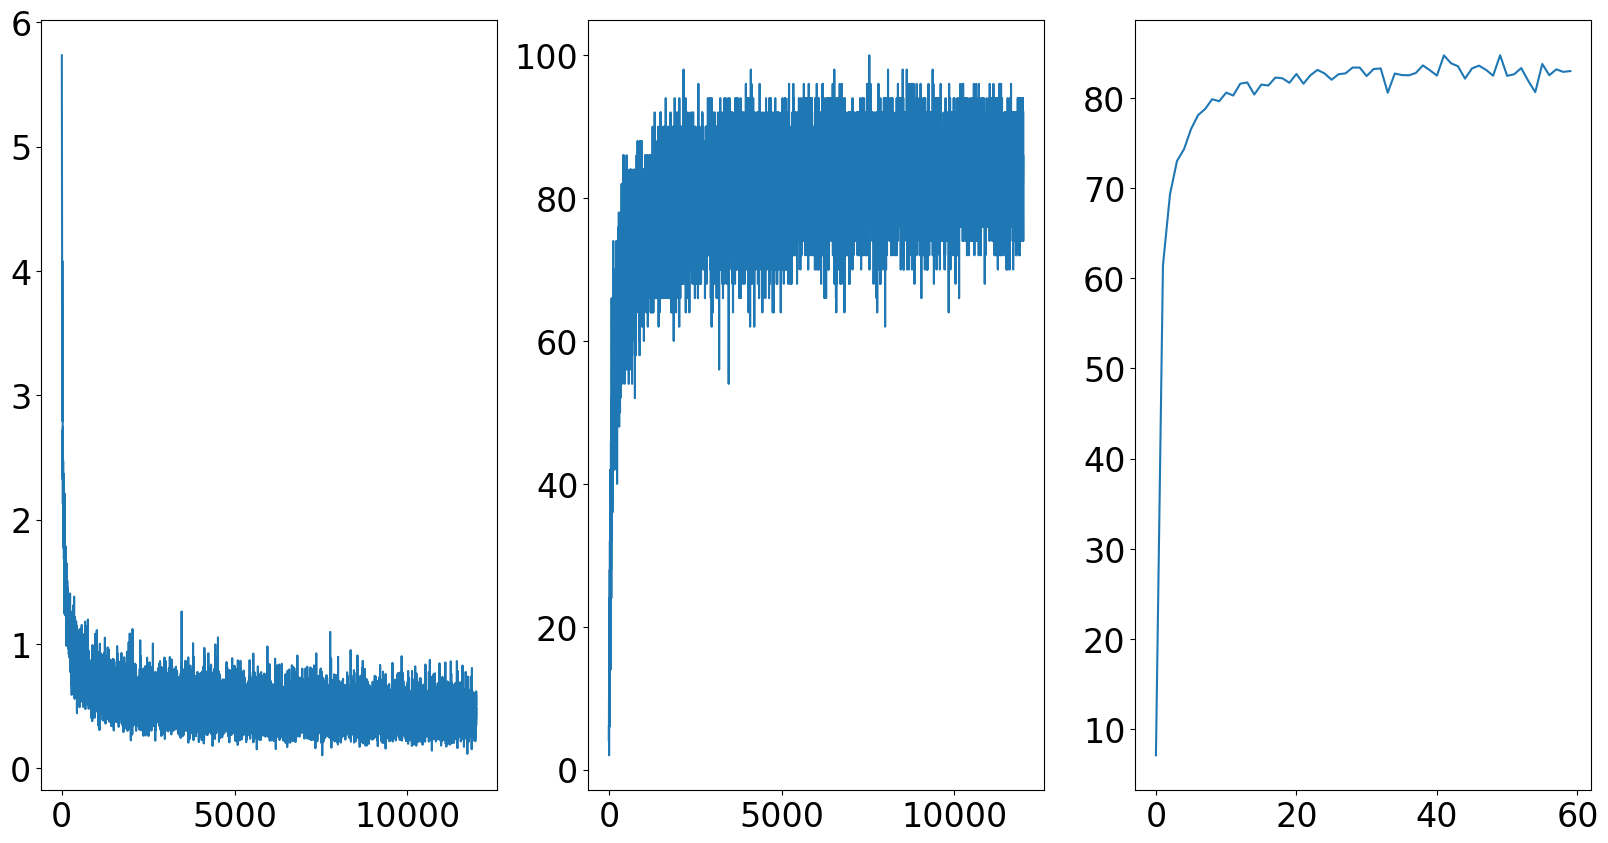

In [35]:
write_show(train_loss5, train_accu5, test_accu5, "-model-freeze-unfreeze")